In [48]:
import numpy as np
import pandas as pd
import pickle
from statsmodels import tsa
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels import multivariate
from statsmodels import regression
import scipy.stats as stats
from statsmodels.sandbox.regression import gmm
from statsmodels.sandbox.regression.gmm import GMM
import statsmodels.stats.diagnostic as smd
from statsmodels.tsa.adfvalues import mackinnonp, mackinnoncrit
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.api as smt
from statsmodels.tsa.vector_ar.hypothesis_test_results import CausalityTestResults
from statsmodels.tsa.vector_ar.var_model import VAR, VARProcess, VARResults
from statsmodels.tsa.vector_ar.vecm import VECM, coint_johansen, select_order
import statsmodels.tsa.arima_model as am
from statsmodels.regression.rolling import RollingOLS
from tabulate import tabulate
import datetime as dt
from dateutil.relativedelta import relativedelta
from datetime import timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, MinuteLocator
from matplotlib.ticker import PercentFormatter
import os
import warnings
from scipy.optimize import minimize, brute
import panel as pn
import altair as alt
from altair import datum
import pandas as pd
import datetime as dt
from pandas_profiling import ProfileReport
import numpy as np
import os
from os import listdir
import warnings
import plotly.figure_factory as ff
import numpy as np
import pandas as pd
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import altair as alt

In [49]:
files=os.listdir("data//USData//")
HospitalData=pd.read_csv("data//covid19-Hospitals.csv")
populationData=pd.read_csv("data//PopulationUSState.csv")
populationData.columns=["state","population"]
populationData["population"]=populationData["population"].str.replace(',','').astype(float)
HospitalData["Inpatient_Bed_Capacity"]=HospitalData["Inpatient_Bed_Capacity"].astype(float)
HospitalData["InBedsOCC_NonCovid"]=HospitalData['InBedsOccAnyPat__Numbeds_Est']-HospitalData['InBedsOccCOVID__Numbeds_Est']
HospitalData["InICUOCC_NonCovid"]=HospitalData['InBedsOccAnyPat__Numbeds_Est']-HospitalData['InBedsOccCOVID__Numbeds_Est']

In [50]:
frames=[]
for file in files:
    df=pd.read_csv("data//USData//"+file)
    df['date']=pd.to_datetime(df['date'])
    df=df.fillna(0)
    df=df.sort_values(by='date',ascending=True)
    frames.append(df)
    #print(df.shape)
final=pd.concat(frames)

In [51]:
StatwiseBeds=HospitalData.groupby(["state"])["Inpatient_Bed_Capacity","ICU_Bed_total_estimate_Capacity","InBedsOCC_NonCovid","InICUOCC_NonCovid"].mean()

In [52]:
final=final.merge(StatwiseBeds,on='state')
final=final.merge(populationData,on='state')
final['total_hospitalizedCurrently_per_capacity']=(final['hospitalizedCurrently']/final['Inpatient_Bed_Capacity']) +(final['InBedsOCC_NonCovid']/100)
# we have assumed that the occupancy of ICU for non covid cases follow same proportion as that of occupancy of Inpatient bed 
final['total_InICUCurrently_per_capacity']=(final['inIcuCurrently']/final['ICU_Bed_total_estimate_Capacity']) +(final['InBedsOCC_NonCovid']/100) 
final=final[final['date']>pd.datetime.strptime('2020-03-04','%Y-%m-%d')]
final["positivityRate"]= final["positiveIncrease"]/ final['totalTestResultsIncrease']
final["positivityRate"]=final["positivityRate"].fillna(0)
final["deathIncrease_per_million"]= final["deathIncrease"]/final["population"]*1000000
final["positivityRate"]=final.positivityRate.replace([np.inf, -np.inf,],1)

In [53]:
final.to_csv("data//USCombined.csv")

In [54]:
final.columns

Index(['date', 'state', 'death', 'deathConfirmed', 'deathIncrease',
       'deathProbable', 'hospitalized', 'hospitalizedCumulative',
       'hospitalizedCurrently', 'hospitalizedIncrease', 'inIcuCumulative',
       'inIcuCurrently', 'negative', 'negativeIncrease',
       'negativeTestsAntibody', 'negativeTestsPeopleAntibody',
       'negativeTestsViral', 'onVentilatorCumulative', 'onVentilatorCurrently',
       'positive', 'positiveCasesViral', 'positiveIncrease', 'positiveScore',
       'positiveTestsAntibody', 'positiveTestsAntigen',
       'positiveTestsPeopleAntibody', 'positiveTestsPeopleAntigen',
       'positiveTestsViral', 'recovered', 'totalTestEncountersViral',
       'totalTestEncountersViralIncrease', 'totalTestResults',
       'totalTestResultsIncrease', 'totalTestsAntibody', 'totalTestsAntigen',
       'totalTestsPeopleAntibody', 'totalTestsPeopleAntigen',
       'totalTestsPeopleViral', 'totalTestsPeopleViralIncrease',
       'totalTestsViral', 'totalTestsViralIncrease'

In [55]:
toDrop_largeMissingValues=[]

In [56]:
states=final['state'].unique()
final['deathIncrease_per_Million']= final['deathIncrease']/final['population']*1000000
data={}
for state in states:
    df=final[final['state']==state]
    profile = ProfileReport(df, title="Pandas Profiling Report",minimal=True)
    profile.to_file("data//USData_Output//"+state+"_output.html")
    #df['deathIncreaseSmooth_pm']=df['deathIncrease_per_Million'].rolling(7, min_periods=1).mean()
    #plt.plot(df['date'],df['deathIncreaseSmooth_pm'],label=state)
#plt.show()

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


KeyboardInterrupt: 

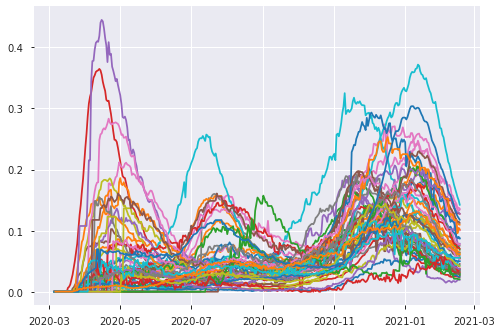

In [57]:
states=final['state'].unique()
data={}
final['month'] = pd.DatetimeIndex(final['date']).month
months=final['month'].unique()
for state in states:
    df=final[final['state']==state]
    df['Covid_hospitalizedCurrently_per_capacity']=(df['hospitalizedCurrently']/df['Inpatient_Bed_Capacity'])
    plt.plot(df['date'],df['Covid_hospitalizedCurrently_per_capacity'],label=state)
plt.show()

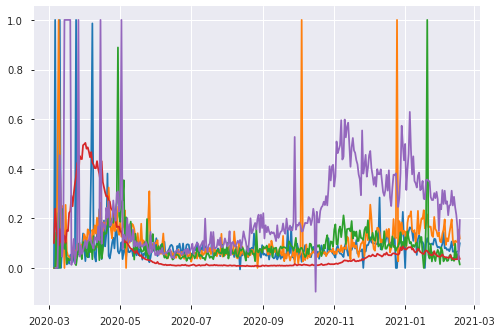

In [58]:
states=final['state'].unique()[:5]
data={}
final['month'] = pd.DatetimeIndex(final['date']).month
months=final['month'].unique()
for state in states:
    df=final[final['state']==state]
    #df['Covid_hospitalizedCurrently_per_capacity']=(df['hospitalizedCurrently']/df['Inpatient_Bed_Capacity'])
    plt.plot(df['date'],df['positivityRate'],label=state)
plt.show()

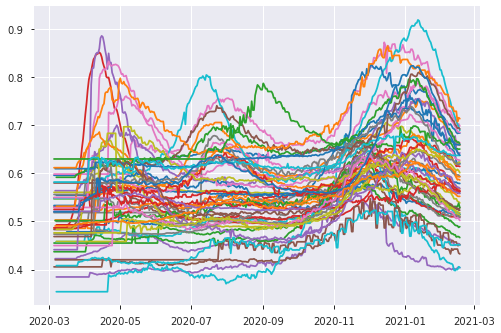

In [59]:
states=final['state'].unique()
data={}
final['month'] = pd.DatetimeIndex(final['date']).month
months=final['month'].unique()
for state in states:
    df=final[final['state']==state]
    df['total_hospitalizedCurrently_per_capacity']=(df['hospitalizedCurrently']/df['Inpatient_Bed_Capacity']) +(df['InBedsOCC_NonCovid']/100)
    plt.plot(df['date'],df['total_hospitalizedCurrently_per_capacity'],label=state)  
plt.show()

In [60]:
stateMonthFrames=[]
states=final['state'].unique()
final['month'] = pd.DatetimeIndex(final['date']).month
months=final['month'].unique()

for state in states:
    df=final[final['state']==state]
      
plt.show()

In [63]:
x=pd.DataFrame(final.groupby(["state","month"])["deathIncrease_per_million"].sum().reset_index())
y=pd.DataFrame(final.groupby(["state","month"])["positivityRate"].mean().reset_index())
new=x.merge(y,on=["state","month"])
new.columns=["state","month","Total_Deaths_per_million","Average_positivity_Rate"]
alt.Chart(new).mark_circle(size=60).encode(
    x="Total_Deaths_per_million",
    y=alt.X('Average_positivity_Rate',
        scale=alt.Scale(domain=(0, 1))),
    color='state',
    tooltip=['state', 'month', 'Total_Deaths_per_million', 'Average_positivity_Rate']
).interactive()

alt.Chart(...)

In [65]:
x=pd.DataFrame(final.groupby(["state","month"])["deathIncrease_per_million"].sum().reset_index())
y=pd.DataFrame(final.groupby(["state","month"])["total_hospitalizedCurrently_per_capacity"].mean().reset_index())
new=x.merge(y,on=["state","month"])
new.columns=["state","month","Total_Deaths_per_million","Average_Occupancy_of_inpatient_beds_per_capacity"]
alt.Chart(new).mark_circle(size=60).encode(
    x="Total_Deaths_per_million",
    y=alt.X('Average_Occupancy_of_inpatient_beds_per_capacity',
        scale=alt.Scale(domain=(0, 1))),
    color='state',
    tooltip=['state', 'month', 'Total_Deaths_per_million', 'Average_Occupancy_of_inpatient_beds_per_capacity']
).interactive()

alt.Chart(...)

In [76]:
states=final['state'].unique()
data={}
final['month'] = pd.DatetimeIndex(final['date']).month
months=final['month'].unique()
for state in states:
    df=final[final['state']==state]
    df['total_hospitalizedCurrently_per_capacity']=(df['hospitalizedCurrently']/df['Inpatient_Bed_Capacity']) +(df['InBedsOCC_NonCovid']/100)
    plt.plot(df['date'],df['total_hospitalizedCurrently_per_capacity'],label=state)  
plt.show()

In [86]:
df.hospitalizedCurrently

17709       0.0
17710       0.0
17711       0.0
17712       0.0
17713       0.0
          ...  
18055    9998.0
18056    9636.0
18057    9299.0
18058    9075.0
18059    8855.0
Name: hospitalizedCurrently, Length: 351, dtype: float64

In [30]:
populationData

,States,Population
0,Alabama,"4,903,185"
1,Alaska,"731,545"
2,Arizona,"7,278,717"
3,Arkansas,"3,017,804"
4,California,"39,512,223"
5,Colorado,"5,758,736"
6,Connecticut,"3,565,287"
7,Delaware,"973,764"
8,District of Columbia,"705,749"
9,Florida,"21,477,737"


In [32]:
final.columns

Index(['date', 'state', 'death', 'deathConfirmed', 'deathIncrease',
       'deathProbable', 'hospitalized', 'hospitalizedCumulative',
       'hospitalizedCurrently', 'hospitalizedIncrease', 'inIcuCumulative',
       'inIcuCurrently', 'negative', 'negativeIncrease',
       'negativeTestsAntibody', 'negativeTestsPeopleAntibody',
       'negativeTestsViral', 'onVentilatorCumulative', 'onVentilatorCurrently',
       'positive', 'positiveCasesViral', 'positiveIncrease', 'positiveScore',
       'positiveTestsAntibody', 'positiveTestsAntigen',
       'positiveTestsPeopleAntibody', 'positiveTestsPeopleAntigen',
       'positiveTestsViral', 'recovered', 'totalTestEncountersViral',
       'totalTestEncountersViralIncrease', 'totalTestResults',
       'totalTestResultsIncrease', 'totalTestsAntibody', 'totalTestsAntigen',
       'totalTestsPeopleAntibody', 'totalTestsPeopleAntigen',
       'totalTestsPeopleViral', 'totalTestsPeopleViralIncrease',
       'totalTestsViral', 'totalTestsViralIncrease'

In [34]:
final.state.unique()

array(['NC', 'VA', 'NE', 'NY', 'IA', 'CO', 'MD', 'FL', 'PA', 'OK', 'MP',
       'PR', 'TX', 'WI', 'MN', 'ND', 'WY', 'NV', 'MO', 'CT', 'SD', 'ME',
       'KY', 'AK', 'OR', 'DE', 'KS', 'GA', 'MT', 'GU', 'UT', 'AZ', 'NM',
       'LA', 'AL', 'MS', 'NJ', 'SC', 'MA', 'MI', 'DC', 'ID', 'WV', 'AS',
       'RI', 'HI', 'VT', 'NH', 'IL', 'IN', 'TN', 'OH', 'WA', 'VI', 'CA',
       'AR'], dtype=object)

In [7]:
os.listdir('data//')

['USpolicy',
 '.ipynb_checkpoints',
 'covid19-Hospitals.csv',
 '3_covidtracking',
 'USData',
 'PopulationUSState.csv',
 'owid-covid-data.csv',
 '2_ecdc',
 'USCombined.csv',
 'Population Estimates by State.csv']

In [22]:
profile = ProfileReport(final, title="Pandas Profiling Report",minimal=True)
profile.to_file("data//USData_Output//""OverallUS_output.html")